# Аналитика деятельности крупного интернет магазина

__Цель: Увеличение выручки компании, проверка гипотез.__

__План работы:__

   1. Подготовка к анализу данных. 

   2. Приоритизация гипотез:
          - Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
          - Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
          - Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.
          
   3. Анализ A/B-теста:
        
      К каждому пункту сделать вывод и предположение:
 
          - Постройте график кумулятивной выручки по группам.
          - Постройте график кумулятивного среднего чека по группам.
          - Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. 
          - Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.
          - Постройте точечный график количества заказов по пользователям.
          - Посчитайте 95-й и 99-й перцентили количества заказов на пользователя.Выберите границу для определения аномальных заказов.
          - Постройте точечный график стоимостей заказов. 
          - Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
          - Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
          - Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
          - Посчитайте статистическую значимость различий в среднем кол-ве заказов на посетителя между группами по «очищенным» данным.
          - Примите решение по результатам теста и объясните его. Варианты решений:
                   1. Остановить тест, зафиксировать победу одной из групп.
                   2. Остановить тест, зафиксировать отсутствие различий между группами.
                   3. Продолжить тест.
          
   4. Выводы и рекомендации.

## Описанние данных

__Таблица hypothesis:__

_Hypothesis_ — краткое описание гипотезы

_Reach__ — охват пользователей по 10-балльной шкале

_Impact_ — влияние на пользователей по 10-балльной шкале

_Confidence_ — уверенность в гипотезе по 10-балльной шкале

_Efforts_ — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

__Таблица orders:__

_transactionId_ — идентификатор заказа;

_visitorId_ — идентификатор пользователя, совершившего заказ;

_date_ — дата, когда был совершён заказ;

_revenue_ — выручка заказа;

_group_ — группа A/B-теста, в которую попал заказ.

__Таблица visitors:__

_date_ — дата;

_group_ — группа A/B-теста;

_visitors_ — количество пользователей в указанную дату в указанной группе A/B-теста

## Подготовка к анализу данных

In [1]:
#Загружаем библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import date, time, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Загружаем данные
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [3]:
# Предварительный анализ данных
display(hypothesis.head(5),orders.head(5),visitors.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
# Преобразование данных даты таблицы orders
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [5]:
# Преобразование данных даты таблицы visitors
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [6]:
# Приведение столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [7]:
#Переименовываем столбцы orders для удобства
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [8]:
# Проверяем на пропуски
print('Колличество пропусков в таблице orders:', orders.isna().sum().sum())
print('Колличество пропусков в таблице hypothesis:', hypothesis.isna().sum().sum())
print('Колличество пропусков в таблице visitors:', visitors.isna().sum().sum())

Колличество пропусков в таблице orders: 0
Колличество пропусков в таблице hypothesis: 0
Колличество пропусков в таблице visitors: 0


In [9]:
# Проверка на дубликаты
print('Колличество дубликатов в таблице orders:',orders.duplicated().sum().sum())
print('Колличество дубликатов в таблице hypothesis:',hypothesis.duplicated().sum().sum())
print('Колличество дубликатов в таблице visitors:',visitors.duplicated().sum().sum())

Колличество дубликатов в таблице orders: 0
Колличество дубликатов в таблице hypothesis: 0
Колличество дубликатов в таблице visitors: 0


__Вывод:__ Данные готовы к анализу

## Приоритизация гипотез

__Описание данных:__

__ICE__ - от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота». Ищется по формуле: ICE = (Impact * Confidence) / Efforts

__RICE__ это модификация RICE с добавлением парраметра Reach и находится по формуле: ICE = (Reach * Impact * Confidence) / Efforts

_Reach_ — скольких пользователей затронет изменение, которое вы хотите внести;

_Impact_ — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

_Confidence_ — насколько вы уверены, что это изменение повлияет на пользователей именно так; 

_Efforts_ — сколько стоит протестировать эту гипотезу. 


### Применяем фреймворк ICE для приоритизации гипотез

In [10]:
# Смотрим названия акций
pd.options.display.max_colwidth = 110
hypothesis.hypothesis

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

In [11]:
hypothesis['ice'] = round(((hypothesis.impact * hypothesis.confidence) / hypothesis.efforts),2)
hypothesis.sort_values(by='ice', ascending = False).head(5)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00


__Вывод:__

Гипотеза 8 заняла 1-е место с показателем ice большим, чем у ближайших конкурентов 0 и 7 гипотез.
Первые три гипотезы по убыванию: 

   - Запустить акцию, дающую скидку на товар в день рождения
   - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
   - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Применяем фреймворк RICE для приоритизации гипотез

In [12]:
hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis.sort_values(by='rice', ascending = False).head(5)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


__Вывод:__

Гипотеза 7 заняла 1-е место с показателем rice вдвое превышающим ближайших конкурентов. При этом гипотеза, занявшая первое место с методом ice оказалась на последнем месте из-за низкого параметра reach. А у победившей гипотезы №7 параметр reach равен 10, что в 10 раз больше, чем у гипотезы № 8.

Для отбора вероятной гипотезы будем использовать фреймворк __RICE__, так как именно в этом фреймворке парраметр reach оценивается отдельно и не подвержен субьективному мнению в отличии от ICE. Фреймворк ICE более предпочтилен, если у нас есть ограничения во времени или мы решаем локальные задачи, не связанные с массовым пользователем.  
 
В качестве гипотезы для исследования берем: __Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок__. 

## Анализ A/B-теста

__Проверка перед началом A/B теста:__

    - Сколько длится тест?
    - Сколько групп учавствуют в тесте?
    - По какому признаку разделены группы
    - Есть ли в данных пользователи, учавствующие в нескольких группах одновременно.

In [13]:
# смотрим период прохождения теста  
orders.date.describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [14]:
print('Общее количество пользователей в обеих группах-', orders['visitor_id'].nunique())
print('Количество пользователей в группе А -', orders.query('group == "A"')['visitor_id'].nunique())
print('Количество пользователей в группе В -', orders.query('group == "B"')['visitor_id'].nunique())

Общее количество пользователей в обеих группах- 1031
Количество пользователей в группе А - 503
Количество пользователей в группе В - 586


In [15]:
# пользователи, попавших в обе группы по таблице orders

duplicated_users = orders.groupby('visitor_id').agg({'group': ['nunique', 'unique']})
duplicated_users.columns = ['groups', 'group_names']
duplicated_users = duplicated_users.query('groups > 1')
display(duplicated_users.head())
len(duplicated_users)

,groups,group_names
visitor_id,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


58

Задублированных пользователей - 58 или ~ 10% в каждой группе. Нам известны только id пользователей, совершивших хоть один платеж, а "неплатящие" неизвестны, то удаление таких пользователей может также исказить результаты в сторону "неплатящих". Оставим их в данных, а результаты будем анализировать предварительно разделив данные по группам А и В.

__Вывод:__

    - Тест проводится в период с 2019-08-01 по 2019-08-31. Даты совпадают в таблицах orders и visitors.
    - В тесте учавствует две группы A и B (контрольная)
    - Данные вероятно разделены по датам. В каждой из дат присутствуют обе группы. 
    - Деление трафика не равномерное. Пользователей категории В на 15% больше чем категории А. В группах может быть неодинаковое колличество участников.Также есть пользователи, которые есть сразу в обеих группах - 58 или ~ 10%. Нам известны только id пользователей, совершивших хоть один платеж, а "неплатящие" неизвестны, то удаление таких пользователей может также исказить результаты в сторону "неплатящих". 
    
Теперь можем начать тестирование. 

### Строим график кумулятивной выручки по группам. 

In [16]:
#Создадим датафрейм из двух столбцов date и group таблицы orders и избавимся от возможных дубликатов
datesGroups = orders[['date','group']].drop_duplicates()

# Обьявляю переменную ordersAggregated
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Обьявляю переменную visitorsAggregated
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                      visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

#Обьединяем таблицы ordersAggregated и visitorsAggregated
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], 
                                        right_on=['date', 'group'])

# Присваиваем новые названия столбцов
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


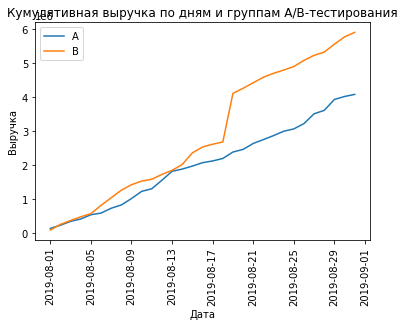

In [17]:
# Обьявляем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# Обьявляем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title("Кумулятивная выручка по дням и группам A/B-тестирования")
plt.legend() 
plt.xticks(rotation=90)
plt.show()

__Вывод:__
Графики обеих групп стабильно растут во времени. При этом наблюдает всплеск выручки в группе В 18 августа и далее стабилизация роста. Возможно в группе В есть аномалии, надо учесть при дальнейших выводах.  

### Строим график кумулятивного среднего чека по группам 

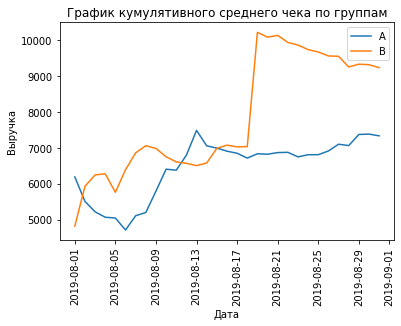

In [18]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title("График кумулятивного среднего чека по группам")
plt.legend() 
plt.xticks(rotation=90)
plt.show()

__Вывод:__
На графике виден общий тренд на рост по обеим группам. 18 августа наблюдается всплеск в группе В. Возможно есть аномалии. Надо учесть при дальнейших выводах.  

### Строим график относительного изменения кумулятивного ср чека группы B к группе A

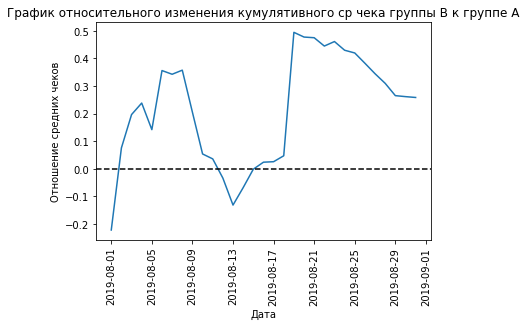

In [19]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')
plt.title("График относительного изменения кумулятивного ср чека группы B к группе A")
plt.xticks(rotation=90)
plt.show()

__Вывод:__
На графике видны положительные скачки средного чека группы В. Видимо те же аномалии в виде крупных заказов. 

### Строим график кумулятивного среднего количества заказов на посетителя по группам.

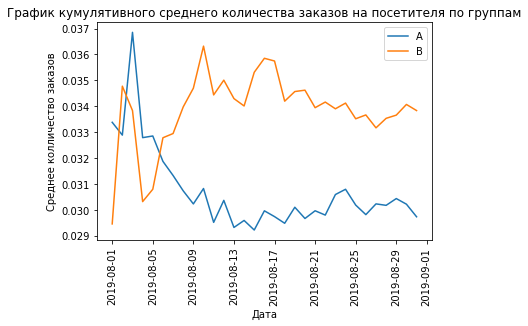

In [20]:
# считаем кумулятивную среднее колличество заказов на посетителя 
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A. Считаем среднее количество заказов на посетителя в группе А
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B. Считаем среднее количество заказов на посетителя в группе В
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xlabel('Дата')
plt.ylabel('Среднее колличество заказов')
plt.title("График кумулятивного среднего количества заказов на посетителя по группам")
plt.xticks(rotation=90)
plt.legend()
plt.show()


__Вывод:__

Группа А показывала лучшее кумулятивное среднее колличество заказов в период с 1-6 августа и стабилизировалась в районе 3%. Начиная с 6 августа группа В вырвалась в лидеры и показывала среднее колличество заказов в среднем на 3-4% больше чем в группе А и стабилизировалась на 3.5%. Интересно, что максимальное (~ 3.7%) и минимальное(~ 2.8%) значение колличества заказов видим в группе А. Такое резкое падение  может быть связано с реакцией пользователей на нововведение. 

### Строим  график относительного изменения кумулятивного ср. кол-ва заказов на посетителя  группы B к группе A

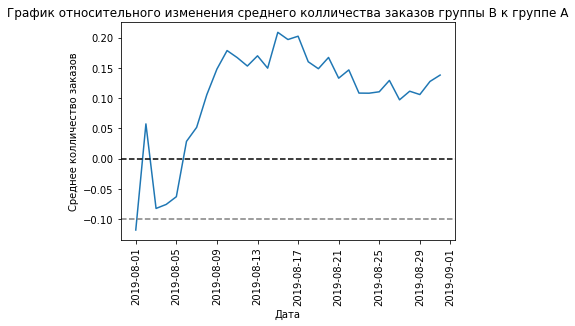

In [21]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
    merge(cumulativeDataB[['date','conversion']],left_on='date', right_on='date', how='left',\
          suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост среднего колличества заказов группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Среднее колличество заказов')
plt.title("График относительного изменения среднего колличества заказов группы B к группе A")
plt.xticks(rotation=90)
plt.show()

__Вывод:__

В период с 1-6 августа кумулятивное cреднее колличество заказов группы В в среднем ниже, чем у группы А. Начинач с 7 августа среднее колличество группы В вырывается вперед и устанавливает лидерство до окончания теста.

### Строим точечный график количества заказов по пользователям

,visitor_id,transaction_id
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


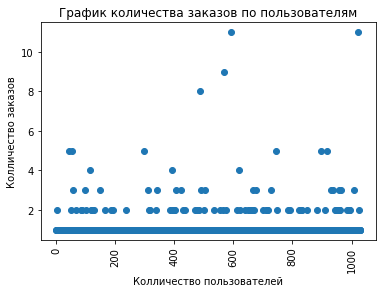

In [22]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'transaction_id']
display(ordersByUsers.sort_values(by='transaction_id',ascending=False).head(5))

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transaction_id'])

plt.xlabel('Колличество пользователей')
plt.ylabel('Колличество заказов')
plt.title("График количества заказов по пользователям")
plt.xticks(rotation=90)
plt.show()

__Вывод:__
Пользователи с 3 и более заказами встречаются редко. Пока не можем считать это аномалиями. Посчитаем выборочные перцентили количества заказов на одного пользователя.

### Считаем 95-й и 99-й перцентили количества заказов на пользователя.

In [23]:
print(np.percentile(ordersByUsers['transaction_id'], [95, 99]))

[2. 4.]


__Вывод:__

Не более 5% пользователей оформляли больше чем 2 заказа. Всего 1% пользователей заказывал более 4 раза. Верхнюю границу числа заказов на одного пользователя установим на 2. Данные с более чем 2 заказами отметаем для чистоты эксперимента.

### Строим график стоимостей заказов

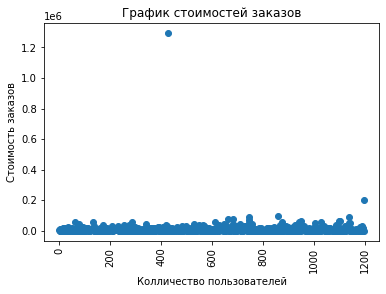

In [24]:
# Строим график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.xlabel('Колличество пользователей')
plt.ylabel('Стоимость заказов')
plt.title("График стоимостей заказов")
plt.xticks(rotation=90)
plt.show()

2 аномальных значения делают график не читабельным. Попробуем их временно исключить.

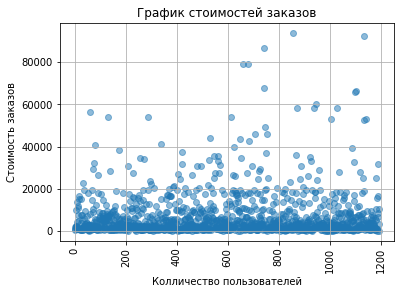

In [25]:
# Посмотрим на график после исключения двух аномальных значений

filter_orders = orders.query('revenue <= 150000')
x_values = pd.Series(range(0,len(filter_orders['revenue'])))
plt.scatter(x_values, filter_orders['revenue'],alpha=0.5)

plt.xlabel('Колличество пользователей')
plt.ylabel('Стоимость заказов')
plt.title("График стоимостей заказов")
plt.grid()
plt.xticks(rotation=90)
plt.show()

### Считаем 95-й и 99-й перцентили стоимостей заказов.

In [26]:

print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Есть выбросы в районе 1 294 500 и 200 000. Менее 5% оформили заказ дороже 28 000 руб и менее 1% пользователей оформили заказы дороже 58 000 руб. Будем считать заказы на сумму более 28 000 аномальными, которые можно отсеять.

### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

__Описание данных:__

date — дата;

_ordersPerDateA_ — количество заказов в выбранную дату в группе A;

_revenuePerDateA_ — суммарная выручка в выбранную дату в группе A;

_ordersPerDateB_ — количество заказов в выбранную дату в группе B;

_revenuePerDateB_ — суммарная выручка в выбранную дату в группе B;

_ordersCummulativeA_ — суммарное число заказов до выбранной даты включительно в группе A;

_revenueCummulativeA_ — суммарная выручка до выбранной даты включительно в группе A;

_ordersCummulativeB_ — суммарное количество заказов до выбранной даты включительно в группе B;

_revenueCummulativeB_ — суммарная выручка до выбранной даты включительно в группе B;

_visitorsPerDateA_ — количество пользователей в выбранную дату в группе A;

_visitorsPerDateB_ — количество пользователей в выбранную дату в группе B;

_visitorsCummulativeA_ — количество пользователей до выбранной даты включительно в группе A;

_visitorsCummulativeB_ — количество пользователей до выбранной даты включительно в группе B.

#### Считаем статистическую значимость различия в среднем количестве заказов между группами.

__Нулевая гипотеза:__ различий в среднем количестве заказов между группами нет. 

__Альтернативная гипотеза:__ различия в среднем между группами есть.

Порог статистической значимости: __alpha = .05__

Анализировать будем статистическим критерием Манна-Уитни, так как в предыдущих шагах мы обнаружили большие выбросы. 

In [27]:
# Создадим переменные ordersByUsersA и ordersByUsersB. В них для пользователей, которые заказывали хотя бы 1 раз, 
#укажем число совершённых заказов. 

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [28]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,\
   index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),name='orders')]\
                    ,axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0,\
   index=np.arange(visitors[visitors['group']=='B']['visitors'].sum()-len(ordersByUsersB['orders'])), name='orders')],\
                    axis=0)

# Применим статистический критерий Манна-Уитни к полученным выборкам
print('P-value по сырым данным равен:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Среднее колличество заказов по сырым данным группы В относительно группы А:',"{0:.3f}"\
      .format(sampleB.mean() / sampleA.mean() - 1))

P-value по сырым данным равен: 0.017
Среднее колличество заказов по сырым данным группы В относительно группы А: 0.138


__Вывод:__

__По «сырым» данным есть различия в среднем числе заказов групп A и B, значит отвергаем нулевую гипотезу.__

Первое число — p-value = 0.017 меньше 0.05. Относительный прирост среднего числа заказов группы B почти на 13.8% опережает в том же показателее в группе А — второе число в выводе.

### Проверим статистическую значимость различий в среднем чеке между сегментами

__Нулевая гипотеза:__ различий в среднем чеке между группами нет. 

__Альтернативная гипотеза:__ различия в среднем чеке между группами есть. 

In [29]:
# найдём относительные различия в среднем чеке между группами
print('P-value по сырым данным равен:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']\
            ['revenue'],orders[orders['group']=='B']['revenue'])[1]))
print('Средний чек заказов по сырым данным группы В относительно группы А:','{0:.3f}'\
 .format(orders[orders['group']=='B']['revenue']\
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value по сырым данным равен: 0.729
Средний чек заказов по сырым данным группы В относительно группы А: 0.259


__Вывод:__

__По «сырым» данным различий в среднем числе заказов групп A и B нет. т.е нулевую гипотезу не отвергаем.__ 

P-value = 0.729 больше 0.05. Однако относительный проигрыш группы А равен почти 26% — второе число в выводе.

### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

#### Сделаем срезы пользователей с аномальными заказами

In [30]:
# Сделаем срезы пользователей с числом заказов больше 2 
usersWithManyOrders = pd.concat(
    [
     ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['transaction_id'],95)]['userId'], 
     ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['transaction_id'],95)]['userId'],
    ],
    axis=0,
)
# Сделаем срез пользователей с суммой заказа более 28000
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'],95)]['visitor_id']                               
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Абсолютное колличество пользователей с аномальными заказами:', abnormalUsers.shape[0])
print('Процент пользователей с аномальными заказами:', round((abnormalUsers.shape[0])/ \
                                                             len(orders['visitor_id'].unique())*100))


1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
Абсолютное колличество пользователей с аномальными заказами: 74
Процент пользователей с аномальными заказами: 7


__Вывод:__ Пользователей с аномальными заказами - 74 или 7%. Узнаем, как их действия повлияли на результаты теста. 

#### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

__Нулевая гипотеза:__ различий в среднем количестве заказов между группами нет. 

__Альтернативная гипотеза:__ различия в среднем между группами есть.

Порог статистической значимости: __alpha = .05__

In [31]:

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим статистический критерий Манна-Уитни к полученным выборкам
print('P-value по очищенным данным равен:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Среднее колличество заказов по очищенным данным группы В относительно группы А:',\
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value по очищенным данным равен: 0.013
Среднее колличество заказов по очищенным данным группы В относительно группы А: 0.173


__Вывод:__

__По «очищенным» данным есть различия в среднем числе заказов групп A и B, значит отвергаем нулевую гипотезу.__

Результаты по среднему кол-ву заказов на посетителя по очищенным данным практически не изменились. p-value немного уменьшилось и составило 0.013, а вот прирост среднего колличества заказов группы В увеличичился на 4% и составил более 17.3%. 

### Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

__Нулевая гипотеза:__ различий в среднем чеке заказа между группами нет. 

__Альтернативная гипотеза:__ различия в среднем чеке заказа между группами есть.

Порог статистической значимости: __alpha = .05__

In [32]:
print('P-value после очищенным данным равен:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Средний чек заказа по очищенным данным группы В относительно группы А:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value после очищенным данным равен: 0.738
Средний чек заказа по очищенным данным группы В относительно группы А: -0.020


__Вывод:__

__По «очищенным» данным нет различия в среднем чеке заказов групп A и B, значит не отвергаем нулевую гипотезу.__

По «очищенным» данным различий в среднем числе заказов групп A и B нет. P-value = 0.738 больше 0.05. Разница средних чеков между группами по очищенным данным сократилась. Средний чек заказов группы А выше среднего чека группы В по очищенным данным на 2%.

# Вывод

В ходе исследования выполнили все поставленные задачи, а именно:

    - Провели предобработку данных для дальнейшего анализа
    - Приоритезировали гипотезы методами ICE и RICE
    - Построили следующие графики в рамках A/B тестирования:
        - График кумулятивной выручки по группам
        - График кумулятивного среднего чека по группам
        - График относительного изменения среднего чека группы В к группе А
        - График кумулятивного среднего колличества заказов по группам
        - График относительного изменения среднего кол-ва заказов группы В к группе А
        - График кол-ва заказов по полльзователям
        - Посчитали выбросы в кол-ве заказов и построили график
        - Посчитали выбросы в стоимостях заказов и построили график
        - Посчитали стат.значимость различий ср. кол-ва заказов между группами по сырым данным
        - Посчитали стат.значимость различий стоимостей заказов между группами по сырым данным
        - Посчитали стат.значимость различий ср. кол-ва заказов между группами по очищенным данным
        - Посчитали стат.значимость различий стоимостей заказов между группами по сырым данным

Методом RICE определили более приоритетную гипотезу для исследования: __Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.__

__Имеющиеся факты:__

    - Графики кумулятивной выручки и кумулятивного среднего чека по группам показывают стабильный рост во времени. При этом наблюдает всплеск в группе В 18 августа и далее стабилизация роста. Лидирует группа В.
    
    - На графике кумулятивного среднего количества заказов на посетителя  Группа А показывала лучшую динамику в период с 1-6 августа и стабилизировалась в районе 3%. Начиная с 6 августа группа В вырвалась в лидеры и показывала среднее колличество заказов в среднем на 3-4% больше чем в группе А и стабилизировалась на 3.5%. Интересно, что максимальное (~ 3.7%) и минимальное(~ 2.8%) значение колличества покупок видим в группе А. Такое резкое падение среднего колличества заказов может быть связано с реакцией пользователей на нововведение.
    
    - Точечные графики количества заказов и их стоимостей показывает наличие аномалий. Не более 5% пользователей оформляли больше чем 2 заказа. Менее 5% пользователей оформили заказ дороже 28 000 руб Будем считать заказы на сумму более 28 000 и заказы более 2 штук аномальными.
    
    - Присутсвует статистически значимые различия по среднему количеству заказов между группами по «сырым» и по данным после фильтрации аномалий. Относительный прирост средней колличества заказов группы B на 14%-17% выше, чем в группе А
    
    - Различия в среднем чеке заказов групп A и B как по "сырым" данным, так и по "очищенным" отсутствуют. Средний чек по "сырым" данным значитель выше в группе В из-за наличия аномалий. Средний чек по "очищенным" данным примерно одинаковый в обеих группах с небольшим преимуществом в группе А.  

__ВЫВОД:__

Тест можно остановить и считать успешно пройденным. Так как после анализа мы видим, что группа В является более успешной, прирост среднего колличества заказов у группы В выше чем у группы А, хотя средний чек не имеет значимых различий между группами.